# Определение перспективного тарифа для телеком-компании
## Описание проекта, цели проекта

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Предобработка данных**
- Приведите данные к нужным типам;
- Найдите и исправьте ошибки в данных, если они есть.
- Есть звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

Посчитать для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

**Анализ данных**
Опишите поведение клиентов оператора, исходя из выборки:
- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
- Посчитать среднее количество, дисперсию и стандартное отклонение. 
- Построить гистограммы. Описать распределения.

**Проверка гипотез**
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

## Изучение данных из файла

**Описание данных**

*Таблица users (информация о пользователях):*
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

*Таблица calls (информация о звонках):*
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

*Таблица messages (информация о сообщениях):*
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

*Таблица internet (информация об интернет-сессиях):*
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

*Таблица tariffs (информация о тарифах):*
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import scipy.stats
from scipy import stats as st
from math import factorial
from scipy.stats import norm

In [2]:
# Создаем словарь ссылок
links_file = {0:['/datasets/users.csv', r'C:\Users\vadim.pilipenko\Downloads\users.csv'],
             1:['/datasets/tariffs.csv',r'C:\Users\vadim.pilipenko\Downloads\tariffs.csv'],
             2:['/datasets/messages.csv',r'C:\Users\vadim.pilipenko\Downloads\messages.csv'],
             3:['/datasets/internet.csv',r'C:\Users\vadim.pilipenko\Downloads\internet.csv'],
             4:['/datasets/calls.csv',r'C:\Users\vadim.pilipenko\Downloads\calls.csv']}
# Создаем функцию открытия файла по ссылкам
def open_fun(dic_links,numb): 
    list_l = dic_links[numb]
    try:
        frame = pd.read_csv(list_l[0])
    except:
        frame = pd.read_csv(list_l[1])
    return frame

users = open_fun(links_file,0)
tariffs = open_fun(links_file,1)
messages = open_fun(links_file,2)
internet = open_fun(links_file,3)
calls = open_fun(links_file,4)

variable_list = [users,tariffs,messages,internet,calls] # Создаем список загруженных сетов данны

for val in variable_list: # функция вывода данных о сетах данных из списка
    display(val.head(10), val.info())
    print('')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


None

**Вывод:**

Оценив первично данные, видно, что требуется обработка пропусков, изменение типов даныых.

## Предобработка данных

Округлим значение звонков до целых минут,заменим тип на int

In [3]:
# округляем звонки в большую сторону до целого, меняем тип на целочисленный
calls['duration'] = calls['duration'].apply(lambda x: np.ceil(x).astype('int32')) 
calls['duration']

0          0
1          0
2          3
3         14
4          6
          ..
202602     1
202603    19
202604    11
202605     5
202606    20
Name: duration, Length: 202607, dtype: int64

Проверим таблицы на наличие дубликатов:

In [4]:
for valu in variable_list:
    print(valu.duplicated().sum())
print('Дубликатов нет, преходим к следующему шагу')


0
0
0
0
0
Дубликатов нет, преходим к следующему шагу


Переведем даты из таблиц из типа objects в datetime, проверим, что в выборке данных только 1 год, чтобы месяцы разных годов не сложились, вернем значение месяца построчно в столбец месяца, затем просуммуируем звонки, интернет и смс за месяц

In [5]:
# Создаем функцию распознания дат в столбцах дат в фреймах данных
def date_recog(data_lists):
    for val in data_lists:
        dt_col = val.columns[val.columns.str.contains(r'date')].tolist() # Ищем столбцы в названии которых есть date
        for i in range(len(dt_col)):
            val.loc[:,dt_col[i]] = pd.to_datetime(val.loc[:,dt_col[i]], format='%Y-%m-%d') # Переводим даты в тип dt
            val['month'] = val.loc[:,dt_col[i]].dt.month # создаем столбец с возратом месяца из даты
            val['day'] = val.loc[:,dt_col[i]].dt.day # создаем столбец с возратом дня из даты
    return data_lists

variable_list = date_recog(variable_list)

# Считаем смс по месяцам
messages_per_month = messages.pivot_table(index=['user_id','month'], values='id',aggfunc='count').reset_index() 

# Считаем траффик по месяцам, переводим из Мб в Гб, округляем в большую сторону до целого, меняем тип на целочисленный
internet_per_month = internet.pivot_table(index=['user_id','month'], values='mb_used',aggfunc='sum').reset_index()
internet_per_month['mb_used'] = internet_per_month['mb_used'].apply(lambda z: np.ceil(z/1024).astype('int32'))

# Считаем звонки по месяцам
calls_per_month = calls.pivot_table(index=['user_id','month'], values='duration' ,aggfunc='sum').reset_index()

print(f'Года, участвующие в выборке:', calls['call_date'].dt.year.unique())

display(messages_per_month.head(10), internet_per_month.head(10), calls_per_month.head(10))


Года, участвующие в выборке: [2018]


,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


,user_id,month,mb_used
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15
5,1000,10,15
6,1000,11,15
7,1000,12,10
8,1001,11,18
9,1001,12,14


,user_id,month,duration
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466
5,1000,10,350
6,1000,11,338
7,1000,12,333
8,1001,11,430
9,1001,12,414


Проверим зависимость звонков, смс и трафика от дня месяца:

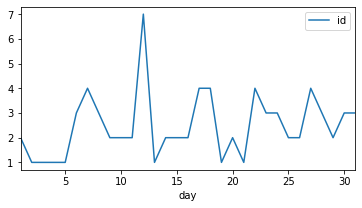

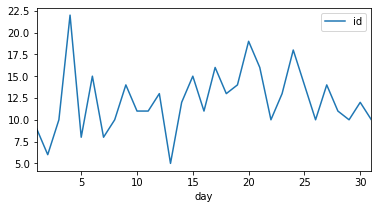

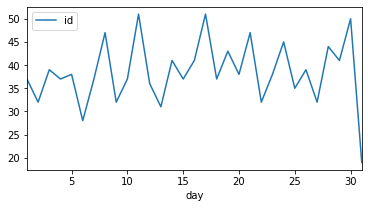

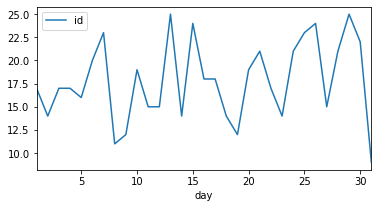

In [6]:
messages_per_day = messages.pivot_table(index=['user_id','day'], values='id',aggfunc='count').reset_index()
for i in range(1002,1006):
    messages_per_day.query('user_id == @i').plot(x='day', y='id', figsize=(6,3))
    plt.show()


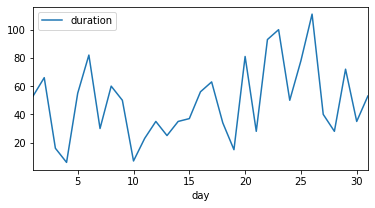

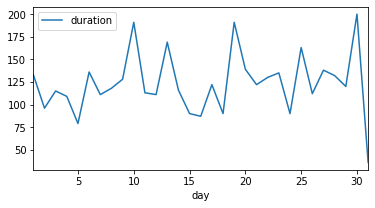

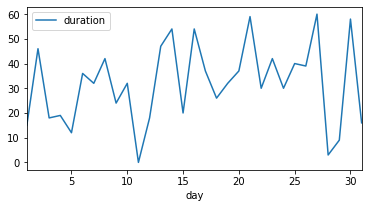

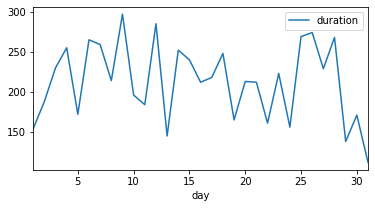

In [7]:
calls_per_day = calls.pivot_table(index=['user_id','day'], values='duration',aggfunc='sum').reset_index()
for i in range(1002,1006):
    calls_per_day.query('user_id == @i').plot(x='day', y='duration', figsize=(6,3))
    plt.show()

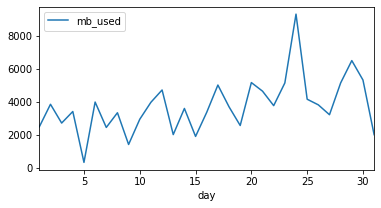

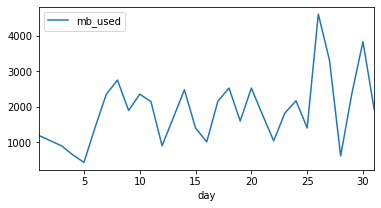

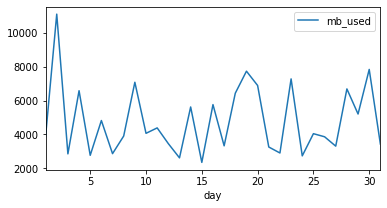

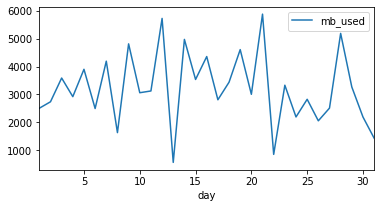

In [8]:
internet_per_day = internet.pivot_table(index=['user_id','day'], values='mb_used',aggfunc='sum').reset_index()
for i in range(1002,1006):
    internet_per_day.query('user_id == @i').plot(x='day', y='mb_used', figsize=(6,3))
    plt.show()

Как видим из графиков, зависимость по смс, звонкам и траффику интернета не зависит от дня месяца, поэтому мы можем считать что распределение по дням месяца равномерное и для статистики активности пользователей датой начала использования тарифа можно пренебречь.

Объединим таблицы Users, Calls, Messages, Internet в общую:

In [9]:
id_lists = users['user_id'].unique().tolist() # Создаем список уникальных пользователей
data_list=[]
for val in id_lists: # Создаем функцию сращивания срезов таблиц по юзеру
    elements = (messages_per_month.query('user_id == @val')
                                .merge(internet_per_month.query('user_id == @val'), on='month', how='outer')
                                .merge(calls_per_month.query('user_id == @val'), on='month', how='outer')
                                .merge(users.query('user_id == @val'), on='user_id', how='outer')
                                 )
    data_list.append(elements) # записывем сращенные таблицы по юзерам в список
data_user_activity = (pd.concat(data_list, sort=True) # объединяем в единую таблицу, удаляем лишнее, переименовываем столбцы
                      .drop(columns = ['user_id_x', 'user_id_y'], axis = 1)
                      .fillna(0)
                      .rename(columns={'duration':'calls_duration','id':'sms_used', 'mb_used':'gb_used', 'month_x':'month', 'month_y':'month_registration'})
                      .reset_index()
                     )
data_user_activity.head()

,index,age,churn_date,city,day,calls_duration,first_name,sms_used,last_name,gb_used,month,month_registration,reg_date,tariff,user_id
0,0,52.0,0,Краснодар,25.0,159.0,Рафаил,22.0,Верещагин,3.0,5.0,5.0,2018-05-25 00:00:00,ultra,1000.0
1,1,52.0,0,Краснодар,25.0,172.0,Рафаил,60.0,Верещагин,23.0,6.0,5.0,2018-05-25 00:00:00,ultra,1000.0
2,2,52.0,0,Краснодар,25.0,340.0,Рафаил,75.0,Верещагин,14.0,7.0,5.0,2018-05-25 00:00:00,ultra,1000.0
3,3,52.0,0,Краснодар,25.0,408.0,Рафаил,81.0,Верещагин,14.0,8.0,5.0,2018-05-25 00:00:00,ultra,1000.0
4,4,52.0,0,Краснодар,25.0,466.0,Рафаил,57.0,Верещагин,15.0,9.0,5.0,2018-05-25 00:00:00,ultra,1000.0


Посчитаем остатки минут, Гб траффика и смс вычтя сумму месяца из включенного в абонетскую плату количества, добавим данные в новые столбцы:

In [10]:
# Считаем остатки минут, интернета, смс по месяцам в зависимости от тарифа
data_user_activity['calls_blnc'] = data_user_activity.apply((lambda y: tariffs.loc[0,'minutes_included'] - y['calls_duration'] if y['tariff'] == tariffs.loc[0,'tariff_name']   else tariffs.loc[1,'minutes_included'] - y['calls_duration']), axis = 1 ).astype('int32')
data_user_activity['internet_blnc'] = data_user_activity.apply((lambda y: tariffs.loc[0,'mb_per_month_included']/1024 - y['gb_used'] if y['tariff'] == tariffs.loc[0,'tariff_name']  else tariffs.loc[1,'mb_per_month_included']/1024 - y['gb_used']), axis = 1 ).astype('int32')
data_user_activity['sms_blnc'] = data_user_activity.apply((lambda y: tariffs.loc[0,'messages_included'] - y['sms_used'] if y['tariff'] == tariffs.loc[0,'tariff_name']  else tariffs.loc[1,'messages_included'] - y['sms_used']), axis = 1 ).astype('int32')
data_user_activity.loc[:15,['calls_blnc','internet_blnc','sms_blnc']]

,calls_blnc,internet_blnc,sms_blnc
0,2841,27,978
1,2828,7,940
2,2660,16,925
3,2592,16,919
4,2534,15,943
5,2650,15,927
6,2662,15,942
7,2667,20,930
8,70,-3,50
9,86,1,50


Посчитаем доплаты за минуты, Гб траффика и смс использованные сверх включенногов тариф, добавим данные в новые столбцы:

In [11]:
def call_surch(data): # функция подсчета денег за минуты свыше включенных в тариф
    if data['calls_blnc'] < 0 and data['tariff'] == tariffs.loc[0,'tariff_name']:
        res = data['calls_blnc']*tariffs.loc[0,'rub_per_minute']
    elif data['calls_blnc'] < 0 and data['tariff'] == tariffs.loc[1,'tariff_name']:
        res = data['calls_blnc']*tariffs.loc[1,'rub_per_minute']
    else:
        res = 0
    return res
data_user_activity['calls_surch_cost'] = data_user_activity.apply(call_surch, axis=1)
data_user_activity['calls_surch_cost'] = data_user_activity['calls_surch_cost'].abs()
data_user_activity['calls_surch_cost']

0         0
1         0
2         0
3         0
4         0
       ... 
3217      0
3218      0
3219      0
3220    336
3221      0
Name: calls_surch_cost, Length: 3222, dtype: int64

In [12]:
def inet_surch(data): # функция подсчета денег за Гб свыше включенных в тариф
    if data['internet_blnc'] < 0 and data['tariff'] == tariffs.loc[0,'tariff_name']:
        res = data['internet_blnc']*tariffs.loc[0,'rub_per_gb']
    elif data['internet_blnc'] < 0 and data['tariff'] == tariffs.loc[1,'tariff_name']:
        res = data['internet_blnc']*tariffs.loc[1,'rub_per_gb']
    else:
        res = 0
    return res
data_user_activity['internet_surch_cost'] = data_user_activity.apply(inet_surch, axis=1)
data_user_activity['internet_surch_cost'] = data_user_activity['internet_surch_cost'].abs()
data_user_activity['internet_surch_cost']

0          0
1          0
2          0
3          0
4          0
        ... 
3217    1200
3218       0
3219     600
3220     600
3221       0
Name: internet_surch_cost, Length: 3222, dtype: int64

In [13]:
def sms_surch(data): # функция подсчета денег за смс свыше включенных в тариф
    if data['sms_blnc'] < 0 and data['tariff'] == tariffs.loc[0,'tariff_name']:
        res = data['sms_blnc']*tariffs.loc[0,'rub_per_message']
    elif data['sms_blnc'] < 0 and data['tariff'] == tariffs.loc[1,'tariff_name']:
        res = data['sms_blnc']*tariffs.loc[1,'rub_per_message']
    else:
        res = 0
    return res
data_user_activity['sms_surch_cost'] = data_user_activity.apply(sms_surch, axis=1)
data_user_activity['sms_surch_cost'] = data_user_activity['sms_surch_cost'].abs()
data_user_activity['sms_surch_cost']

0        0
1        0
2        0
3        0
4        0
        ..
3217     0
3218     0
3219     0
3220    27
3221    48
Name: sms_surch_cost, Length: 3222, dtype: int64

Посчитаем помесячно общую сумму абонетской платы и доплат, добавим данные в новую колонку:

In [14]:
def total_cost(data): # функция подсчета общей суммы за месяц
    if  data['tariff'] == tariffs.loc[0,'tariff_name']:
        res = (tariffs.loc[0,'rub_monthly_fee']
               + data['calls_surch_cost']
               + data['internet_surch_cost']
               + data['sms_surch_cost']
              )
    else:
        res =(tariffs.loc[1,'rub_monthly_fee']
               + data['calls_surch_cost']
               + data['internet_surch_cost']
               + data['sms_surch_cost']
              )
    return res
data_user_activity['total_cost'] = data_user_activity.apply(total_cost, axis=1)

data_user_activity['total_cost']

0       1950
1       1950
2       1950
3       1950
4       1950
        ... 
3217    1750
3218     550
3219    1150
3220    1513
3221     598
Name: total_cost, Length: 3222, dtype: int64

**Вывод:**

Заменили пропуски, посчитали помесячно данные для всех таблиц, посчитал данные помесячно без привязки к дате регистрации, т.к. статистически расход минут, Гб и смс распределен равномерно и привязка к календарным месяцам а не к циклам оплаты от даты регистрации не внесет значительных искажений. Затем объединил таблицы, посчитал остатки минут, Гб и смс, посчитал доплаты за минуты, Гб и смс по тарифам и посчитал помесячные выплаты аб.платы + доплаты.

## Анализ данных

Создадим срезы по тарифам и по локации Москва/не Москва

In [15]:
# Создаем переменные со срезами для анализа данных
data_smart = data_user_activity.query('tariff == "smart"')
data_ultra = data_user_activity.query('tariff == "ultra"')
data_moscow = data_user_activity.query('city == "Москва"')
data_non_moscow = data_user_activity.query('city != "Москва"')

display(data_smart.head(), data_ultra.head())

,index,age,churn_date,city,day,calls_duration,first_name,sms_used,last_name,gb_used,...,reg_date,tariff,user_id,calls_blnc,internet_blnc,sms_blnc,calls_surch_cost,internet_surch_cost,sms_surch_cost,total_cost
8,0,41.0,0,Москва,1.0,430.0,Иван,0.0,Ежов,18.0,...,2018-11-01 00:00:00,smart,1001.0,70,-3,50,0,600,0,1150
9,1,41.0,0,Москва,1.0,414.0,Иван,0.0,Ежов,14.0,...,2018-11-01 00:00:00,smart,1001.0,86,1,50,0,0,0,550
10,0,59.0,0,Стерлитамак,17.0,117.0,Евгений,4.0,Абрамович,11.0,...,2018-06-17 00:00:00,smart,1002.0,383,4,46,0,0,0,550
11,1,59.0,0,Стерлитамак,17.0,214.0,Евгений,11.0,Абрамович,18.0,...,2018-06-17 00:00:00,smart,1002.0,286,-3,39,0,600,0,1150
12,2,59.0,0,Стерлитамак,17.0,289.0,Евгений,13.0,Абрамович,20.0,...,2018-06-17 00:00:00,smart,1002.0,211,-5,37,0,1000,0,1550


,index,age,churn_date,city,day,calls_duration,first_name,sms_used,last_name,gb_used,...,reg_date,tariff,user_id,calls_blnc,internet_blnc,sms_blnc,calls_surch_cost,internet_surch_cost,sms_surch_cost,total_cost
0,0,52.0,0,Краснодар,25.0,159.0,Рафаил,22.0,Верещагин,3.0,...,2018-05-25 00:00:00,ultra,1000.0,2841,27,978,0,0,0,1950
1,1,52.0,0,Краснодар,25.0,172.0,Рафаил,60.0,Верещагин,23.0,...,2018-05-25 00:00:00,ultra,1000.0,2828,7,940,0,0,0,1950
2,2,52.0,0,Краснодар,25.0,340.0,Рафаил,75.0,Верещагин,14.0,...,2018-05-25 00:00:00,ultra,1000.0,2660,16,925,0,0,0,1950
3,3,52.0,0,Краснодар,25.0,408.0,Рафаил,81.0,Верещагин,14.0,...,2018-05-25 00:00:00,ultra,1000.0,2592,16,919,0,0,0,1950
4,4,52.0,0,Краснодар,25.0,466.0,Рафаил,57.0,Верещагин,15.0,...,2018-05-25 00:00:00,ultra,1000.0,2534,15,943,0,0,0,1950


Посчитаем для тарифов среднее, медиану, дисперсию и стандартное отклонение для звонков, траффика интернета и смс

In [16]:
# создаем вспомогательные переменные со списками для анализа данных
columns_list=['calls_duration','gb_used','sms_used']
data_list=[data_smart, data_ultra]
data_city=[data_moscow,data_non_moscow]
tariff_l = ['Smart','Ultra']
city_l = ['Москва', 'Не Москва']

for i in range(len(data_list)): # функция подсчета средней, медианы, дисперсии и стандартного отклонения
    for val in columns_list:
        print(f''' Для тарифа {tariff_l[i]} для {val} 
    Среднее: {round(data_list[i][val].mean())},
    медиана: {round(data_list[i][val].median(),2)},
    дисперсия:{round(np.var(data_list[i][val],),2)},
    стандартное отконение: {round(np.std(data_list[i][val], ddof=1),2)}
    ''')

 Для тарифа Smart для calls_duration 
    Среднее: 419,
    медиана: 422.0,
    дисперсия:35953.57,
    стандартное отконение: 189.66
    
 Для тарифа Smart для gb_used 
    Среднее: 16,
    медиана: 17.0,
    дисперсия:33.29,
    стандартное отконение: 5.77
    
 Для тарифа Smart для sms_used 
    Среднее: 33,
    медиана: 28.0,
    дисперсия:798.52,
    стандартное отконение: 28.26
    
 Для тарифа Ultra для calls_duration 
    Среднее: 542,
    медиана: 525.0,
    дисперсия:95367.98,
    стандартное отконение: 308.98
    
 Для тарифа Ultra для gb_used 
    Среднее: 19,
    медиана: 19.0,
    дисперсия:99.47,
    стандартное отконение: 9.98
    
 Для тарифа Ultra для sms_used 
    Среднее: 49,
    медиана: 39.0,
    дисперсия:2197.63,
    стандартное отконение: 46.9
    


Построим для тарифов графики распределения количества использованных минут, траффика интернета и смс.

Построим для локации Москва/не Москва графики распределения количества использованных минут, траффика интернета и смс.

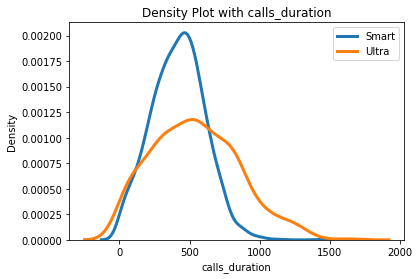

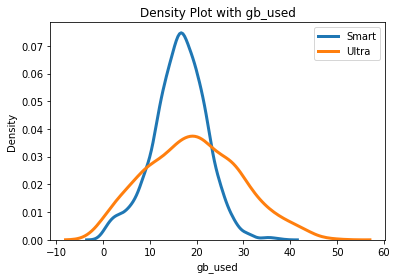

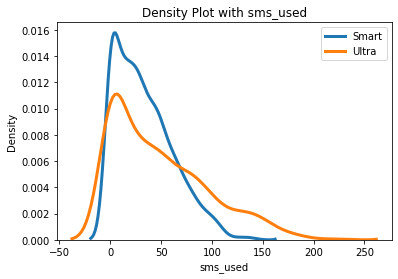

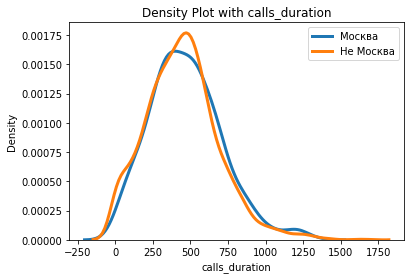

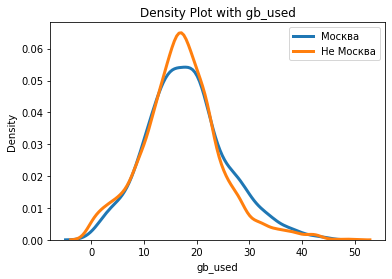

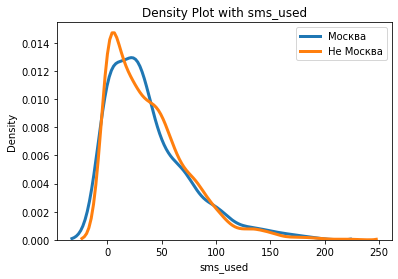

In [17]:
for val in columns_list: # функция построения графика распределения с разделением по тарифам
    for i in range(len(data_list)):
        subset = data_list[i][val]
        sbn.distplot(subset, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = tariff_l[i])
        plt.title('Density Plot with '+val)
        plt.xlabel(val)
        plt.ylabel('Density')
    plt.show()
    
for val in columns_list: # функция построения графика распределения с разделением по городам
    for i in range(len(data_city)):
        subset = data_city[i][val]
        sbn.distplot(subset, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = city_l[i])
        plt.title('Density Plot with '+val)
        plt.xlabel(val)
        plt.ylabel('Density')
    plt.show()

In [18]:
print(f''' Для тарифа Smart для total_cost 
    Среднее: {round(data_smart['total_cost'].mean())},
    медиана: {round(data_smart['total_cost'].median(),2)},
    дисперсия:{round(np.var(data_smart['total_cost']),2)},
    стандартное отконение: {round(np.std(data_smart['total_cost'], ddof=1),2)}
    ''')
print(f''' Для тарифа Ultra для total_cost 
    Среднее: {round(data_ultra['total_cost'].mean())},
    медиана: {round(data_ultra['total_cost'].median(),2)},
    дисперсия:{round(np.var(data_ultra['total_cost']),2)},
    стандартное отконение: {round(np.std(data_ultra['total_cost'], ddof=1),2)}
    ''')

 Для тарифа Smart для total_cost 
    Среднее: 1290,
    медиана: 1023.0,
    дисперсия:670545.64,
    стандартное отконение: 819.05
    
 Для тарифа Ultra для total_cost 
    Среднее: 2070,
    медиана: 1950.0,
    дисперсия:143000.27,
    стандартное отконение: 378.35
    


**Вывод:**

Для тарифа Ультра количество включенных в аб. плату смс значительно превышает и среднее и 3сигмы для пользователей количество использованных смс, количество включенных в аб. плату минут так же превышает и среднее и 3сигмы для пользователей количество использованных минут, доплаты за смс и минуты для пользователей тарифа Ультра практически отсутствуют.
Для тарифа Ультра количество включенных в аб. плату Гб трафика больше среднего примерно на стандартное отклонение, доплаты достаточно характерны.

Для тарифа Смарт количество включенных в аб. плату смс превышает среднее примерно на стандартное отклонение, доплаты достаточно характерны.
Количество включенных в аб. плату минут чуть больше среднего значения, доплаты за минуты использованные сверх включенных в аб.плату характерны чуть меньее чем для половины пользователей тарифа Смарт.
Для тарифа Смарт количество включенных в аб. плату Гб трафика меньше среднего, доплаты за Гб, потраченные сверх включенных в аб.плату характерны больее половины пользователей тарифа.

## Проверка гипотез

*Гипотеза 1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.*

Для проверки формируем 0-гипотезу от обратного:
*средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковые*, проверим:

In [19]:

alpha = 0.01 # возьмем 1%, т.к. для генеральной выборки в миллионы пользователей статистическая значимость 5% выглядит недостоверной

results = st.ttest_ind(
   data_smart['total_cost'],
   data_ultra['total_cost']) # проверьте гипотезу о равенстве средних выручек двух тарифов по выборкам

print('p-значение:', results.pvalue)

if results.pvalue < alpha: # сравниваем получившееся p-значение с заданным уровнем статистической значимости:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.7573403948209683e-156
Отвергаем нулевую гипотезу


Следовательно, гипотеза *"средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются"* достоверная с заданной статистической значимостью.

*Гипотеза 2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов*

Для проверки формируем 0-гипотезу от обратного:
*средняя выручка пользователей из Москвы и выручка пользователей из других регионов одинаковые*, проверим:

In [20]:
alpha = 0.05

results = st.ttest_ind(
   data_moscow['total_cost'],
   data_non_moscow['total_cost']) # ваш код: проверьте гипотезу о равенстве средних выручек независимых совокупностей Москва и остальные города

print('p-значение:', results.pvalue)

if results.pvalue < alpha: # сравниваем получившееся p-значение с заданным уровнем статистической значимости:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5825526152658022
Не получилось отвергнуть нулевую гипотезу


Следовательно, гипотеза *"средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"* не достоверная с заданной статистической значимостью.

**Вывод:**

Проверили две гипотезы, результатом исследования стало:

Гипотеза *"средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются"* достоверная с заданной статистической значимостью.

Гипотеза *"средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"* не достоверная с заданной статистической значимостью.

## Общий вывод

Для тарифа Ультра количество включенных в аб. плату смс значительно превышает и среднее и 3сигмы для пользователей количество использованных смс, количество включенных в аб. плату минут так же превышает и среднее и 3сигмы для пользователей количество использованных минут, доплаты за смс и минуты для пользователей тарифа Ультра практически отсутствуют.
Для тарифа Ультра количество включенных в аб. плату Гб трафика больше среднего примерно на стандартное отклонение, доплаты достаточно характерны.

Для тарифа Смарт количество включенных в аб. плату смс превышает среднее примерно на стандартное отклонение, доплаты достаточно характерны.
Количество включенных в аб. плату минут чуть больше среднего значения, доплаты за минуты использованные сверх включенных в аб.плату характерны чуть меньее чем для половины пользователей тарифа Смарт.
Для тарифа Смарт количество включенных в аб. плату Гб трафика меньше среднего, доплаты за Гб, потраченные сверх включенных в аб.плату характерны больее половины пользователей тарифа.

Проверили две гипотезы, результатом исследования стало:

Гипотеза *"средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются"* достоверная с заданной статистической значимостью.

Гипотеза *"средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"* не достоверная с заданной статистической значимостью.

**Среднемесячная выручка для тарифа Smart = 1290 рублей, среднемесячная выручка для тарифа Ultra = 2070 рублей для выборки.
Тариф Ультра приносит больше выручки, достоверное утверждение для генеральной совокупности данных с заданной статистической значимостью в 1%**